In [1]:
import numpy as np
from PIL import Image
import os
import json
import torch

import sklearn.metrics as metrics
import torchvision.transforms.v2 as tfs
import torch.utils.data as data
from mpmath.identification import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

Используемое устройство: cuda


Epoch 1/15: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s, Train Loss=17.4597, Train Acc=30.96%]


Val Loss: 8.6325, Val Acc: 53.47%


Epoch 2/15: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s, Train Loss=8.9754, Train Acc=39.91%]


Val Loss: 2.4285, Val Acc: 51.49%


Epoch 3/15: 100%|██████████| 14/14 [00:03<00:00,  3.65it/s, Train Loss=0.9629, Train Acc=54.36%]


Val Loss: 1.1015, Val Acc: 56.44%


Epoch 4/15: 100%|██████████| 14/14 [00:03<00:00,  3.57it/s, Train Loss=0.7127, Train Acc=57.34%]


Val Loss: 0.9972, Val Acc: 55.45%


Epoch 5/15: 100%|██████████| 14/14 [00:04<00:00,  3.32it/s, Train Loss=0.9949, Train Acc=57.57%]


Val Loss: 0.9055, Val Acc: 55.45%


Epoch 6/15: 100%|██████████| 14/14 [00:04<00:00,  3.36it/s, Train Loss=0.8699, Train Acc=65.37%]


Val Loss: 0.9496, Val Acc: 59.41%


Epoch 7/15: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s, Train Loss=0.6368, Train Acc=68.58%]


Val Loss: 0.8651, Val Acc: 67.33%


Epoch 8/15: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s, Train Loss=0.5549, Train Acc=71.33%]


Val Loss: 0.9353, Val Acc: 61.39%


Epoch 9/15: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s, Train Loss=0.5105, Train Acc=69.72%]


Val Loss: 0.8948, Val Acc: 55.45%


Epoch 10/15: 100%|██████████| 14/14 [00:03<00:00,  3.58it/s, Train Loss=0.5421, Train Acc=71.33%]


Val Loss: 0.8745, Val Acc: 56.44%


Epoch 11/15: 100%|██████████| 14/14 [00:04<00:00,  3.36it/s, Train Loss=0.4356, Train Acc=75.00%]


Val Loss: 0.8750, Val Acc: 62.38%


Epoch 12/15: 100%|██████████| 14/14 [00:03<00:00,  3.57it/s, Train Loss=1.1210, Train Acc=76.15%]


Val Loss: 0.8629, Val Acc: 67.33%


Epoch 13/15: 100%|██████████| 14/14 [00:04<00:00,  3.49it/s, Train Loss=0.3833, Train Acc=77.52%]


Val Loss: 0.8709, Val Acc: 61.39%


Epoch 14/15: 100%|██████████| 14/14 [00:03<00:00,  3.57it/s, Train Loss=0.6491, Train Acc=75.69%]


Val Loss: 0.9941, Val Acc: 62.38%


Epoch 15/15: 100%|██████████| 14/14 [00:03<00:00,  3.51it/s, Train Loss=0.6396, Train Acc=76.61%]


Val Loss: 0.9759, Val Acc: 58.42%


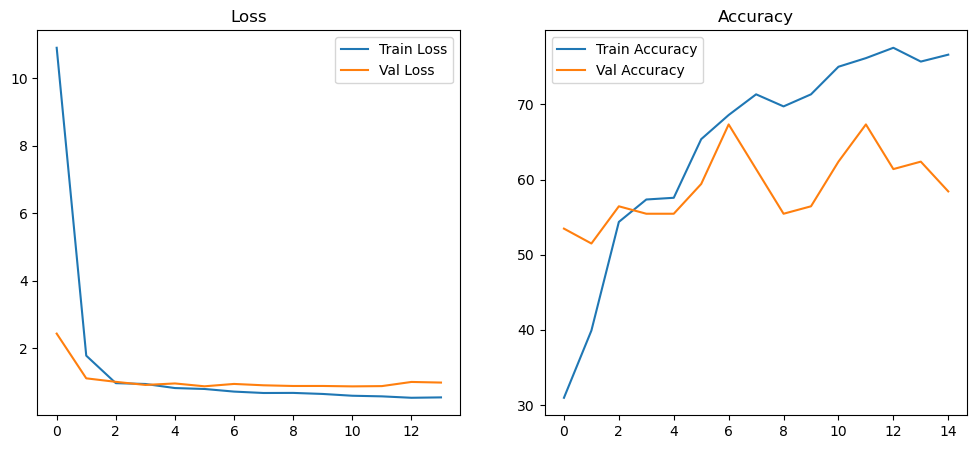

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Считывание данных 
class TrainDataset(data.Dataset):
    def __init__(self, path, sample, transform=None):
        self.path = os.path.join(path, sample)
        self.transform = transform

        with open(os.path.join(self.path, "format.json"), "r") as fp:
            self.format = json.load(fp)

        self.length = 0
        self.files = []
        self.targets = torch.eye(4)

        for _dir, _target in self.format.items():
            path = os.path.join(self.path, _dir)
            list_files = os.listdir(path)
            self.length += len(list_files)
            self.files.extend(map(lambda _x: (os.path.join(path, _x), _target), list_files))

    def __getitem__(self, item):
        path_file, target = self.files[item]
        t = self.targets[target]
        img = Image.open(path_file)

        if self.transform:
            img = self.transform(img)

        return img, t

    def __len__(self):
        return self.length

# Архитектура свёрточной нейросети
class EnhancedVagonCNN(nn.Module):
    def __init__(self):
        super(EnhancedVagonCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # [32, 32, 256, 256]
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # [32, 32, 128, 128]

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # [32, 64, 128, 128]
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # [32, 64, 64, 64]

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # [32, 128, 64, 64]
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # [32, 128, 32, 32]

        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Преобразование фотографий
transformations = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
d_train = TrainDataset("data/class_vagon", sample='train', transform=transformations)
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)

v_train = TrainDataset("data/class_vagon", sample='valid', transform=transformations)
valid_data = data.DataLoader(v_train, batch_size=32, shuffle=False)

model = EnhancedVagonCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 15

best_val_loss = float('inf')
patience = 5
no_improve = 0

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    # Обучение
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_tqdm = tqdm(train_data, leave=True, desc=f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, (images, labels) in enumerate(train_tqdm):
        images, labels = images.to(device), labels.argmax(dim=1).to(device)  # Преобразование one-hot в классы

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_tqdm.set_postfix({
            "Train Loss": f"{loss.item():.4f}",
            "Train Acc": f"{100 * correct_train / total_train:.2f}%"
        })

    train_tqdm.close()
    avg_train_loss = train_loss / len(train_data)
    train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in valid_data:
            images, labels = images.to(device), labels.argmax(dim=1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(valid_data)
    val_accuracy = 100 * correct_val / total_val
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Ранняя остановка
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'][1:], label='Train Loss')
plt.plot(history['val_loss'][1:], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()


In [25]:
# Оценка алгоритма

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
d_test = TrainDataset('data/class_vagon', sample='test', transform=transformations)
test_data = data.DataLoader(d_test, batch_size=32, shuffle=False)

all_predictions = []
all_labels = []

with torch.no_grad():
    for x_test, y_test in test_data:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        p = model(x_test)
        p = torch.argmax(p, dim=1).cpu().numpy()
        y = torch.argmax(y_test, dim=1).cpu().numpy()

        all_predictions.extend(p)
        all_labels.extend(y)

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

accuracy = metrics.accuracy_score(all_labels, all_predictions)
precision = metrics.precision_score(all_labels, all_predictions, average='macro', zero_division=0)
recall = metrics.recall_score(all_labels, all_predictions, average='macro', zero_division=0)
f1 = metrics.f1_score(all_labels, all_predictions, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.7358
Precision: 0.7423
Recall: 0.7521
F1-score: 0.7153


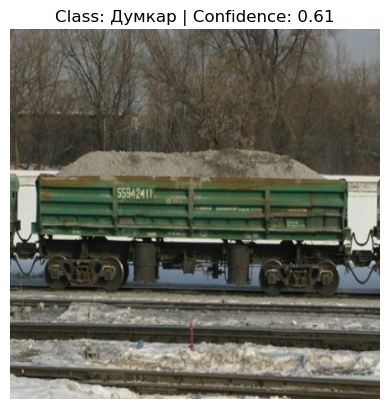

Предсказанный класс: Думкар (Уверенность: 61.44%) Вероятность для классов: tensor([[0.6144, 0.1284, 0.2101, 0.0471]], device='cuda:0')


In [10]:
# Точечная проверка результатов

def OneImage(base_path):
    with open(os.path.join(base_path, "format.json"), "r") as fp:
        format_data = json.load(fp)

    files = []
    lenght = 0

    for _dir, _target in format_data.items():
        dir_path = os.path.join(base_path, _dir)  # Используем base_path, а не path
        list_files = os.listdir(dir_path)
        lenght += len(list_files)
        image_files = [f for f in list_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        files.extend(map(lambda _x: os.path.join(dir_path, _x), image_files))

    random_number = np.random.randint(0, len(files))

    return files[random_number]


def preprocess_image(image_path, img_size=256):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()])
    image = Image.open(image_path).convert('RGB')

    return transform(image).unsqueeze(0)


model.eval()


def predict(image_path, model, class_names):
    input_tensor = preprocess_image(image_path).to(device)

    # Предсказание
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        conf, pred_class = torch.max(probs, 1)

    # Визуализация
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Class: {class_names[pred_class.item()]} | Confidence: {conf.item():.2f}')
    plt.axis('off')
    plt.show()

    return pred_class.item(), conf.item(), probs


class_names = {
    0: 'Думкар',
    1: 'Крытый вагон',
    2: 'Полувагон',
    3: 'Цистерна'
}

# Путь к вашему тестовому изображению
image_path = OneImage('data/class_vagon/test')
pred_class, confidence, probability = predict(image_path, model, class_names)
print(
    f'Предсказанный класс: {class_names[pred_class]} (Уверенность: {confidence:.2%}) Вероятность для классов: {probability}')

In [8]:
image_path = 'scale_1200.png'
info = model(preprocess_image(image_path).to(device))
probability = F.softmax(info, dim=1)